Rachel Sheinberg
July 2023

Step 1: Importing Original Folders 

In [2]:
import os
import pandas as pd

# Define the root directory where your folders are located
root_directory = 'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/data/data/'

# Create an empty dictionary to store the DataFrames
df_dict = {}

# Iterate over each folder
folders = os.listdir(root_directory)
for folder_name in folders:
    folder_path = os.path.join(root_directory, folder_name)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
    
        # Get a list of files in the folder
        files = os.listdir(folder_path)
        
        # Iterate over each file in the folder
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            
            # Check if the path is a file
            if os.path.isfile(file_path):
            
                # Read the file as a DataFrame and store it in the dictionary
                key = os.path.join(folder_name, file_name)
                df = pd.read_csv(file_path)
        
                
                # Select specific columns
                selected_columns = ['timestamp',
                                   'units_represented','out.site_energy.total.energy_consumption.kwh',
                                   'out.electricity.total.energy_consumption.kwh','out.fuel_oil.total.energy_consumption.kwh',
                                   'out.natural_gas.total.energy_consumption.kwh','out.propane.total.energy_consumption.kwh',
                                    ]
                df = df[selected_columns]
               
                # Accounting for units represented to get load of single unit
                df['elec.consumed'] = df['out.electricity.total.energy_consumption.kwh'] / df['units_represented']
                df['nat_gas.consumed'] = df['out.natural_gas.total.energy_consumption.kwh'] / df['units_represented']
                df['total.consumed'] = df['out.site_energy.total.energy_consumption.kwh'] / df['units_represented']
                df['elec.load'] = df['elec.consumed'] / .25
                df['nat_gas.load'] = df['nat_gas.consumed'] / .25
                df['total_load'] = df['total.consumed'] / .25
                df_dict[key] = df

Step 2: Create Dictionary for User Interface

In [3]:
# creating a dictionary to match the names i've assigned the folders to the excel values

# first get the strings from excel options
nrel = df_dict.keys()
excel_homes = ("Mobile Home", "Multi-Family 2-4 Units", "Multi-Family 5+ Units", "Single Family Attached", "Single Family Detached")
excel_upgrades = ("Baseline", "Basic Enclosure", "Enhanced Enclosure", "Heat Pumps and High Efficiency Electric Backup",
                  "Heat Pumps and Min Efficiency Electric Backup","Heat Pumps and Min Efficiency Existing Heating as Backup",
                  "Heat Pump and Water Heaters", "Whole Home Electrification High Efficiency", "Whole Home Electrification High Efficiency Plus Basic Enclosure Package",
                  "Whole Home Electrification High Efficiency Plus Enhanced Enclosure Package", "Whole Home Electrification Min Efficiency")

# Creating a third list by concatenating strings from list1 and list2
excel = []
for string1 in excel_upgrades:
    for string2 in excel_homes:
        excel.append(string1 + ": " + string2)
        
# Creating a dictionary using a loop and zip()
excel_to_nrel = {}
for excel, nrel in zip(excel, nrel):
    excel_to_nrel[excel] = nrel

## I now have a dictionary to transfer from excel to the file name, and a dictionary to tranfer from the file name to values 
## within that file! 

Step 3: Import Data from Current Interface Type (Excel Spreadsheet) 

In [35]:
file_path = r'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/electric_calculator.xlsm'
# Read Dataframe from Excel file
inputs = pd.read_excel(file_path, sheet_name='Python')

In [37]:
# selecting the correct files from user input -- using dictionary 
start = str(inputs.iloc[1,1]) + ": " + str(inputs.iloc[0,1]) ## combining starting electrification and home type
upgrade = str(inputs.iloc[2,1]) + ": " + str(inputs.iloc[0,1]) ## combining upgrade and home type
upgrade_only = str(inputs.iloc[2,1])
nrel_start = excel_to_nrel[start] ## translate to nrel filename
start_data = df_dict[nrel_start] ## select data from the dictionary 
nrel_upgrade = excel_to_nrel[upgrade] ## translate to nrel filename
upgrade_data = df_dict[nrel_upgrade] ## select data from the dictionary 

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

# Retrieve the column data from the four columns I care about here for the starting  loads 
timestamps = pd.to_datetime(start_data['timestamp'])
start_elec_values = start_data['elec.consumed']
start_gas_values = start_data['nat_gas.consumed']
start_total_values = start_data['total.consumed']
start_elec_load = start_data['elec.load']

# Retrieve the column data from the four columns i care about here - ending loads
upgrade_timestamps = pd.to_datetime(upgrade_data['timestamp'])
upgrade_elec_values = upgrade_data['elec.consumed']
upgrade_gas_values = upgrade_data['nat_gas.consumed']
upgrade_total_values = upgrade_data['total.consumed']
upgrade_elec_load = upgrade_data['elec.load']

In [39]:
## normalizing starting values
total = sum(start_elec_values)  # Calculate the sum of all values
scaled_start_elec_values = [x/total for x in start_elec_values]  # Scale each value
total = sum(start_gas_values)  # Calculate the sum of all values
scaled_start_gas_values = [x/total for x in start_gas_values]  # Scale each value
total = sum(start_total_values)  # Calculate the sum of all values
scaled_start_total_values = [x/total for x in start_total_values]  # Scale each value
total = sum(start_elec_load) 
scaled_start_elec_load = [x/total for x in start_elec_load]

## normalizing upgrade values
total = sum(upgrade_elec_values)  # Calculate the sum of all values
scaled_upgrade_elec_values = [x/total for x in upgrade_elec_values]  # Scale each value
total = sum(upgrade_gas_values)  # Calculate the sum of all values
scaled_upgrade_gas_values = [x/total for x in upgrade_gas_values]  # Scale each value
total = sum(upgrade_total_values)  # Calculate the sum of all values
scaled_upgrade_total_values = [x/total for x in upgrade_total_values]  # Scale each value
total = sum(upgrade_elec_load) 
scaled_upgrade_elec_load = [x/total for x in upgrade_elec_load]

Step 4: Scale up with User Inputs

In [40]:
file_path = r'C:\Users\Rachel\OneDrive - UCLA IT Services\Documents\DWP_Electrification_Cal\Multipliers.csv'
multipliers = pd.read_csv(file_path) ## using multipliers between starting and ending upgrade status
multiplier_key = nrel_start + "\\" + nrel_upgrade.split("\\")[0] ## identify correct multiplier based on user inputs

In [41]:
 #identify specific multipliers for the user-entered combination, based on start and end type and elec and nat gas usage
vals = multipliers[multipliers['name'] == multiplier_key] ## multipliers based on start type --> end type 

# create multipliers based on user inputted annual energy use
start_elec_mult = float(inputs.iloc[3,1]) ## user inputted electricity usage
upgrade_elec_mult = float(inputs.iloc[3,1] * vals['elec_mult'].iloc[0]) ## user inputted usage multiplied for upgrade type
start_nat_gas_mult = float(inputs.iloc[4,1]*29.3) ## user inputted natural gas usage
upgrade_nat_gas_mult = float(inputs.iloc[4,1]*29.3 * vals['nat_gas_mult'].iloc[0]) ## user inputted usage multiplied for upgrade type
start_total_mult = float(inputs.iloc[3,1]+ inputs.iloc[4,1]*29.3) ## total usage, sum of electricity inputted and natural gas; translating natural gas therms to kwh 
upgrade_total_mult = float((inputs.iloc[3,1]+inputs.iloc[4,1]*29.3) * vals['total_mult'].iloc[0]) ## total usage multiplied for upgrade type
start_elec_load_mult = float(inputs.iloc[3,1]*4) ## user inputted electricity usage divided by hours in the year to get load
upgrade_elec_load_mult = float(inputs.iloc[3,1]*4*vals['elec_mult'].iloc[0]) ## elec load multiplied for upgrade type 

In [42]:
## Create a new dataframe containing scaled up values for the starting and ending upgrade statuses 

start_elec_vals = [x * start_elec_mult for x in scaled_start_elec_values] ## starting electricity usage
upgrade_elec_vals = [x * upgrade_elec_mult for x in scaled_upgrade_elec_values] ## upgrade electricity usage
start_nat_gas_vals = [x * start_nat_gas_mult for x in scaled_start_gas_values] ## starting natural gas usage
upgrade_nat_gas_vals = [x * upgrade_nat_gas_mult for x in scaled_upgrade_gas_values] ## upgrade natural gas usage
start_total_vals = [x * start_total_mult for x in scaled_start_total_values] ## starting total usage
upgrade_total_vals = [x * upgrade_total_mult for x in scaled_upgrade_total_values] ## upgrage total usage
start_elec_load = [x * start_elec_load_mult for x in scaled_start_elec_load]
upgrade_elec_load = [x * upgrade_elec_load_mult for x in scaled_upgrade_elec_load]
df = pd.DataFrame({
    'Timestamps': timestamps,
    'start_elec_vals': start_elec_vals,
    'upgrade_elec_vals': upgrade_elec_vals,
    'start_nat_gas_vals': start_nat_gas_vals,
    'upgrade_nat_gas_vals': upgrade_nat_gas_vals,
    'start_total_vals': start_total_vals,
    'upgrade_total_vals': upgrade_total_vals,
    'start_elec_load' : start_elec_load,
    'upgrade_elec_load' : upgrade_elec_load
    
})
print(df)


               Timestamps  start_elec_vals  upgrade_elec_vals  \
0     2018-01-01 00:15:00         0.180787           0.285666   
1     2018-01-01 00:30:00         0.182264           0.289947   
2     2018-01-01 00:45:00         0.181441           0.290644   
3     2018-01-01 01:00:00         0.181015           0.292821   
4     2018-01-01 01:15:00         0.172421           0.292934   
...                   ...              ...                ...   
35035 2018-12-31 23:00:00         0.203762           0.297263   
35036 2018-12-31 23:15:00         0.191869           0.286613   
35037 2018-12-31 23:30:00         0.193215           0.290244   
35038 2018-12-31 23:45:00         0.193841           0.293435   
35039 2019-01-01 00:00:00         0.195267           0.298974   

       start_nat_gas_vals  upgrade_nat_gas_vals  start_total_vals  \
0                1.636327              0.022913          1.403565   
1                1.670334              0.022913          1.427710   
2           

Step 5: Plot the Energy use before and after upgrade

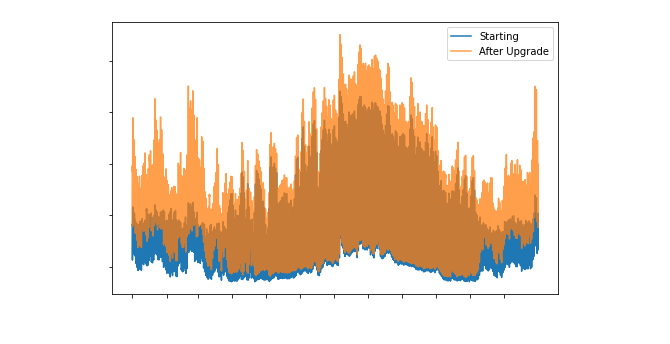

In [44]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_elec_vals)
plt.plot(timestamps, upgrade_elec_vals, alpha = 0.75)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Electricity Usage - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])
plt.show()

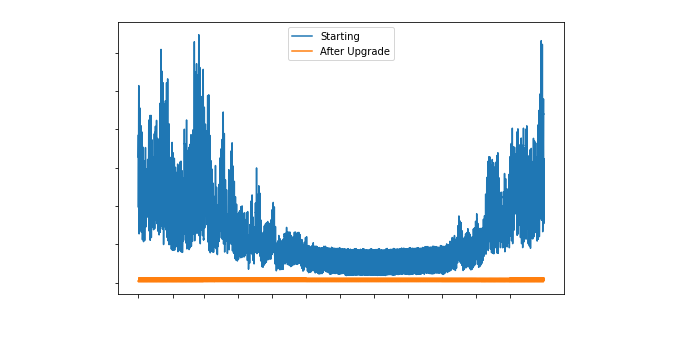

In [54]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_nat_gas_vals)
plt.plot(timestamps, upgrade_nat_gas_vals)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Natural Gas Usage - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])           
plt.show()

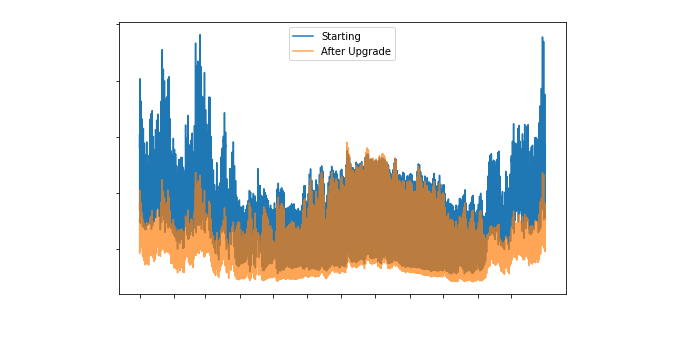

In [45]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_total_vals)
plt.plot(timestamps, upgrade_total_vals, alpha = 0.7)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Total Energy Usage - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])
plt.show()

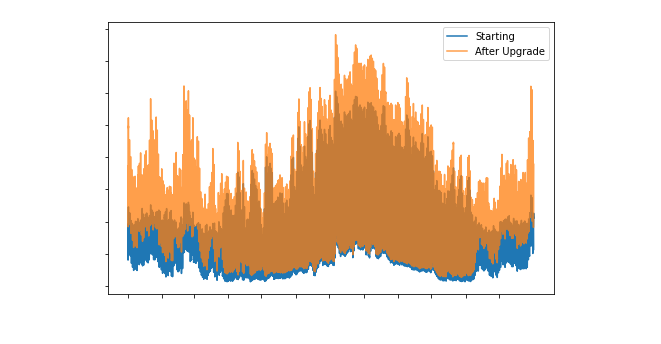

In [46]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_elec_load)
plt.plot(timestamps, upgrade_elec_load, alpha = 0.75)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Electricity Load - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])
plt.show()

In [47]:
## Creating a new dataframe to hold the energy values and add in cost values
# Make sure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['Timestamps'])

# Set the 'datetime' column as the index for easier grouping by month
df.set_index('datetime', inplace=True)

# Resample the data to monthly frequency and calculate the sum for each set of data
monthly_sums = df.resample('M').sum()

# Reset the index to get the 'Timestamps' column back as a regular column
monthly_sums.reset_index(inplace=True)
monthly_sums['start_elec_cost'] = 0
monthly_sums['upgrade_elec_cost'] = 0

print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       457.342786         672.178203         3572.929049   
1  2018-02-28       400.927284         578.185885         2862.617832   
2  2018-03-31       398.725350         551.038047         2544.937061   
3  2018-04-30       405.605596         494.409459         1513.261189   
4  2018-05-31       451.404061         523.560391         1259.256129   
5  2018-06-30       572.845846         641.221022          942.784931   
6  2018-07-31       751.835545         847.205920          873.061840   
7  2018-08-31       709.553801         798.850436          880.552556   
8  2018-09-30       572.398569         642.538221          917.880223   
9  2018-10-31       447.039923         519.137994         1188.392049   
10 2018-11-30       388.670478         510.476425         2018.664307   
11 2018-12-31       443.455494         648.435775         3399.051514   
12 2019-01-31         0.195267           0.298974  

Step 6: Calculate Electricity and Natural Gas Costs Before and After Upgrade

In [49]:
file_path = r'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/electric_pricing.xlsx'
# Read Dataframe from Excel file
elec_prices = pd.read_excel(file_path, sheet_name='resi')

In [50]:
zone = int(inputs.iloc[5,1])
for x in range(12):
    start_elec_usage = monthly_sums['start_elec_vals'].iloc[x]
    upgrade_elec_usage = monthly_sums['upgrade_elec_vals'].iloc[x]
    if zone == 1:
        if start_elec_usage <= 350:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En charge T1'].iloc[x]*start_elec_usage
        elif start_elec_usage <= 1150:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + elec_prices['En Charge T2'].iloc[x]*start_elec_usage
        else: 
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + elec_prices['En Charge T3'].iloc[x]*start_elec_usage 
        if upgrade_elec_usage <= 350:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En charge T1'].iloc[x]*upgrade_elec_usage
        elif upgrade_elec_usage <= 1150:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + elec_prices['En Charge T2'].iloc[x]*upgrade_elec_usage
        else: 
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + elec_prices['En Charge T3'].iloc[x]*upgrade_elec_usage 
    else: 
        if elec_usage <= 500:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En Charge T1'].iloc[x]*start_elec_usage
        elif elec_usage <= 1500:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + elec_prices['En Charge T2'].iloc[x]*start_elec_usage 
        else: 
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + elec_prices['En Charge T3'].iloc[x]*start_elec_usage
        if upgrade_elec_usage <= 500:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En charge T1'].iloc[x]*upgrade_elec_usage
        elif upgrade_elec_usage <=1500:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + elec_prices['En Charge T2'].iloc[x]*upgrade_elec_usage
        else: 
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + elec_prices['En Charge T3'].iloc[x]*upgrade_elec_usage 
print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       457.342786         672.178203         3572.929049   
1  2018-02-28       400.927284         578.185885         2862.617832   
2  2018-03-31       398.725350         551.038047         2544.937061   
3  2018-04-30       405.605596         494.409459         1513.261189   
4  2018-05-31       451.404061         523.560391         1259.256129   
5  2018-06-30       572.845846         641.221022          942.784931   
6  2018-07-31       751.835545         847.205920          873.061840   
7  2018-08-31       709.553801         798.850436          880.552556   
8  2018-09-30       572.398569         642.538221          917.880223   
9  2018-10-31       447.039923         519.137994         1188.392049   
10 2018-11-30       388.670478         510.476425         2018.664307   
11 2018-12-31       443.455494         648.435775         3399.051514   
12 2019-01-31         0.195267           0.298974  

C:\Users\Rachel\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [55]:
## accounting for lifeline or EZ-Save, Utility Users Tax (UUT)
if inputs.iloc[7,1] == 'Lifeline':
    monthly_sums['start_elec_cost'] = monthly_sums['start_elec_cost'] - 17.71 ## no UUT, Lifeline discount
    monthly_sums['upgrade_elec_cost'] = monthly_sums['upgrade_elec_cost'] - 17.71 ## no UUT, Lifeline discount
elif inputs.iloc[7,1] == 'EZ-Save':
    monthly_sums['start_elec_cost'] = (monthly_sums['start_elec_cost'] - 8.17)*1.1 ## adding UUT, EZ-Save discount
    monthly_sums['upgrade_elec_cost'] = (monthly_sums['upgrade_elec_cost'] - 8.17)*1.1 ## adding UUT, EZ-Save discount
else: 
    monthly_sums['start_elec_cost'] = monthly_sums['start_elec_cost']*1.1 ## adding UUT, no discount
    monthly_sums['upgrade_elec_cost'] = monthly_sums['upgrade_elec_cost'] *1.1 ## adding UUT, no discount

#remove the extraneous row 
monthly_sums = monthly_sums.iloc[:-1,:]

# create yearly sums from all of the months 
sum_row = monthly_sums.iloc[:, 1:].sum(numeric_only=True)
monthly_sums = monthly_sums.append(sum_row, ignore_index = True)


print(monthly_sums)
print(sum(monthly_sums['start_elec_cost']), sum(monthly_sums['upgrade_elec_cost']))

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       457.342786         672.178203         3572.929049   
1  2018-02-28       400.927284         578.185885         2862.617832   
2  2018-03-31       398.725350         551.038047         2544.937061   
3  2018-04-30       405.605596         494.409459         1513.261189   
4  2018-05-31       451.404061         523.560391         1259.256129   
5  2018-06-30       572.845846         641.221022          942.784931   
6  2018-07-31       751.835545         847.205920          873.061840   
7  2018-08-31       709.553801         798.850436          880.552556   
8  2018-09-30       572.398569         642.538221          917.880223   
9  2018-10-31       447.039923         519.137994         1188.392049   
10 2018-11-30       388.670478         510.476425         2018.664307   
11 2018-12-31       443.455494         648.435775         3399.051514   
12        NaT      5999.804733        7427.237778  

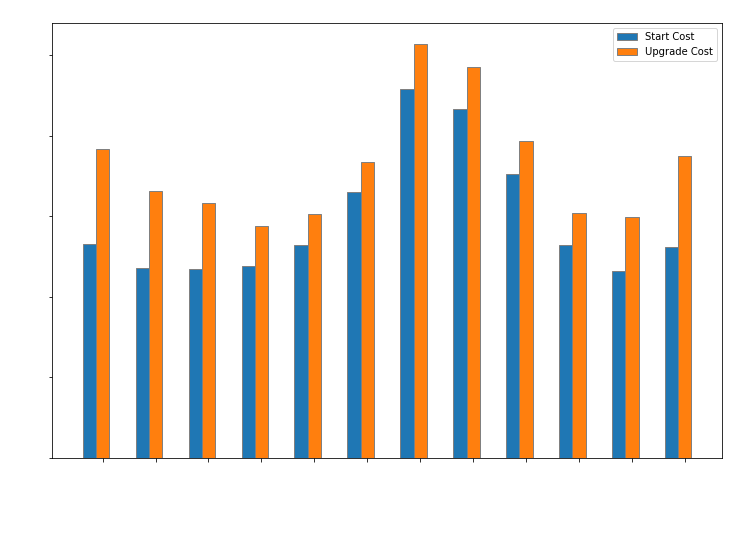

In [56]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
starting_cost = monthly_sums['start_elec_cost'][:-1]
upgrade_cost = monthly_sums['upgrade_elec_cost'][:-1]

 
# Set position of bar on X axis
br1 = np.arange(len(starting_cost))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, starting_cost, width = barWidth,
        edgecolor ='grey', label ='Start Cost')
plt.bar(br2, upgrade_cost,  width = barWidth,
        edgecolor ='grey', label ='Upgrade Cost')
 
# Adding Xticks
plt.xlabel('Month', fontweight ='bold', fontsize = 12, color = 'white')
plt.ylabel('Cost ($)', fontweight ='bold', fontsize = 15, color = 'white')
plt.xticks([r + barWidth for r in range(len(starting_cost))],
        ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December'])

plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.title('Monthly Electricity Cost - ' + start + " vs. " + upgrade_only, fontweight = 'bold', color = 'white')
plt.legend()
plt.show()

In [53]:
from prettytable import PrettyTable
table = PrettyTable()
column_names = ["Month", "Bill Pre Upgrade", "Bill After Upgrade"]
data_columns =[
     ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December','Total'],
    monthly_sums['start_elec_cost'],
    monthly_sums['upgrade_elec_cost']
    ]
# Add columns to the table
for name, data in zip(column_names, data_columns):
    table.add_column(name, data)

# Align columns to the left
for name in column_names:
    table.align[name] = "l"

# Format the salary column as dollars and cents
starting_column_index = column_names.index('Electric Bill Pre Upgrade')
for row in table._rows:
    row[starting_column_index] = "${:.2f}".format(float(row[starting_column_index]))
    
# Format the salary column as dollars and cents
upgrade_column_index = column_names.index('Electric Bill After Upgrade')
for row in table._rows:
    row[upgrade_column_index] = "${:.2f}".format(float(row[upgrade_column_index]))
    
# Add a horizontal line after the header row
table.horizontal_char = '-'

# Add a vertical line between columns
table.vertical_char = '|'

# Add an intersection character between the columns and the header row
table.junction_char = '+'

# Print the table
print(table)

+-----------+------------------+--------------------+
| Month     | Bill Pre Upgrade | Bill After Upgrade |
+-----------+------------------+--------------------+
| January   | $120.94          | $174.04            |
| February  | $106.99          | $150.80            |
| March     | $106.45          | $144.09            |
| April     | $108.56          | $130.59            |
| May       | $119.92          | $137.83            |
| June      | $150.06          | $167.03            |
| July      | $208.20          | $233.60            |
| August    | $196.93          | $220.72            |
| September | $160.39          | $179.08            |
| October   | $119.89          | $137.95            |
| November  | $105.27          | $135.78            |
| December  | $118.99          | $170.34            |
| Total     | $1622.58         | $1981.85           |
+-----------+------------------+--------------------+


Next Step: Natural Gas Pricing 

In [ ]:
file_path = r'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/ng_pricing_res.xlsx'
# Read Dataframe from Excel file
gas_prices = pd.read_excel(file_path, sheet_name='Residential')